In [78]:
import os
import pandas as pd
import numpy as np
from zipline import run_algorithm
from zipline.pipeline import Pipeline
from zipline.data.bundles.core import load
from zipline.pipeline.data import USEquityPricing
from zipline.pipeline.factors import AverageDollarVolume, CustomFactor, Returns
from zipline.api import (
    attach_pipeline,
    calendars,
    pipeline_output,
    date_rules,
    time_rules,
    set_commission, 
    set_slippage,
    record,
    order_target_percent,
    get_open_orders,
    get_datetime,
    schedule_function
)
import pandas_datareader as web
import warnings
warnings.filterwarnings('ignore')

In [13]:
os.environ["QUANDL_APL_KEY"] = "APIKEY"
bundle_data = load("quandl", os.environ, None)

In [47]:
# the number of long and short stocks
N_LONGS = N_SHORTS = 50

In [49]:
# custom momentum factor
class MomentumFactor(CustomFactor):
    inputs = [USEquityPricing.close, Returns(window_length=126)] # specifies the data we need to use
    window_length = 252 # 1 year of trading days
    
    def compute(self, today, assets, out, prices, returns): # calculates the momentum factor
        out[:] = (
            (prices[-21] - prices[-252]) / prices[-252] # (long-term) compares the price of a month ago to prices from 1 year ago, short-term performance compared to long-term
            - (prices[-1] - prices[-21]) / prices[-21] # (short-term) compares most recent prices to last months prices 
        ) / np.nanstd(returns, axis=0) # divides by standard deviation of returns to normalize for volatility

In [51]:
# function which will creates the stock selection pipeline
def make_pipeline(): # return a pipeline object - which let us define factors from columns of data. They process large data to give a set of assets with high exposure to our desired factors
    momentum = MomentumFactor() # calls our Momentum factor function to calculate the momentum score for our stocks
    dollar_volume = AverageDollarVolume( # use built-in Zipline factor to calculate the average daily dollar volume
        window_length=30) 
    return Pipeline(
        columns={ # The data need to compute for each asset
            "factor": momentum, # momentum score
            "longs": momentum.top(N_LONGS), # the top 50 stocks by momentum score
            "shorts" : momentum.bottom(N_SHORTS), # the bottom stocks by momentum score
            "ranking" : momentum.rank(), # rank of each stock 
        },
        screen=dollar_volume.top(100), # filter to top 100 stocks, by liquidity, so that easy and cheaper to trade
    )

In [53]:
# function to start everyday with new stock selection data to use for trading decisions
def before_trading_start(context, data): # context is data that is shared across our different functions, data object to give market data
    context.factor_data = pipeline_output( # extracts the results from our factor pipepline, things like factor rankings, longs, etc.
        "factor_pipeline"
    )

In [55]:
# configuration function for when the backtest starts to use our stock selector and set our portfolio rebalance to the start of the week
def initialize(context): # use our context object which stores state data
    attach_pipeline(make_pipeline(), "factor_pipeline") # we create a pipeline, then attach that pipeline to our 'factor_pipeline'
    schedule_function ( # This function schedules when the algo should rebalance the portfolio, which at the start of each week
        rebalance, # the name of function it calls
        date_rules.week_start(), # run at the start of the week
        time_rules.market_open(), # run when markets open
        calendar=calendars.US_EQUITIES, # use the US equities market timetable
    )

In [57]:
# a function that contains the logic to rebalance our portfolio. 
def rebalance(context, data): # we pass it our states data storing object, and our market data access object
    factor_data = context.factor_data # extracts the pipeline data
    record(factor_data=factor_data.ranking) # use the record() method to save the factor rankings for analysis
    assets = factor_data.index # our filtered 100 stocks by dollar volume
    record(prices=data.current(assets, "price")) # retrieves the price data for these 100 stocks
    longs = assets[factor_data.longs] # uses boolean masks to select top 50 stocks
    shorts = assets[factor_data.shorts] # uses boolean masks to selct bottom 50 stocks
    divest = set(
        context.portfolio.positions.keys()) - set( # this creates a set of all current positions 
            longs.union(shorts)) # then we minus the set of stocks to long or short, leaving any stocks we don't want 
    exec_trades(
        data,
        assets=divest,
        target_percent=0
    )
    exec_trades( 
        data,
        assets=longs,
        target_percent=1 / N_LONGS # each long position should be 1/50th(2%) of the portfolio
    )
    exec_trades(
        data,
        assets=shorts,
        target_percent=-1 / N_SHORTS # each short position should be -1/50th(-2%) of the portfolio
    )
# maintaing these exposure levels (100% long/-100% short) ensures that the strategy's performance is driven by security selection and not fluctuations in overall market exposure


In [59]:
# function which loops through the provided assets and executes the orders
def exec_trades(data, assets, target_percent): # Assets are the stocks to trade, target perent is the portfolio allocation for each asset
    for asset in assets:
        if data.can_trade(asset) and not get_open_orders(asset): # checks if we can trade the stock or not, and checks if there pending orders for this asset, stop duplicates
            order_target_percent(asset, target_percent) # places the order based on asset we want and target percent to see how many shares to buy or sell


In [80]:
# run the backtest using the 'run_algorithm' function
start = pd.Timestamp("2016-01-01") # periods on which to backtest
end = pd.Timestamp("2018-12-31")
perf = run_algorithm( # zipline's run_algorithm function
    start=start,
    end=end,
    initialize=initialize,
    before_trading_start=before_trading_start,
    capital_base=100000, # beginning portfolio value
    bundle="quandl", 
)

In [63]:
perf.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 754 entries, 2016-01-04 21:00:00+00:00 to 2018-12-31 21:00:00+00:00
Data columns (total 39 columns):
 #   Column                   Non-Null Count  Dtype              
---  ------                   --------------  -----              
 0   period_open              754 non-null    datetime64[ns, UTC]
 1   period_close             754 non-null    datetime64[ns, UTC]
 2   longs_count              754 non-null    int64              
 3   shorts_count             754 non-null    int64              
 4   long_value               754 non-null    float64            
 5   short_value              754 non-null    float64            
 6   long_exposure            754 non-null    float64            
 7   pnl                      754 non-null    float64            
 8   short_exposure           754 non-null    float64            
 9   capital_used             754 non-null    float64            
 10  orders                   754 non-null    object  

<Axes: title={'center': 'Cumulative returns'}>

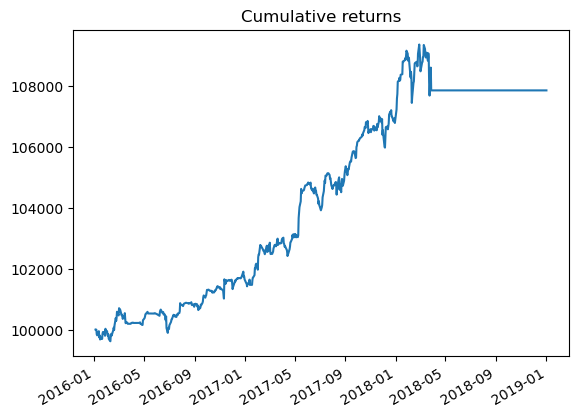

In [72]:
# Graph of the algorithm's performance
perf.portfolio_value.plot(title="Cumulative returns")

<Axes: >

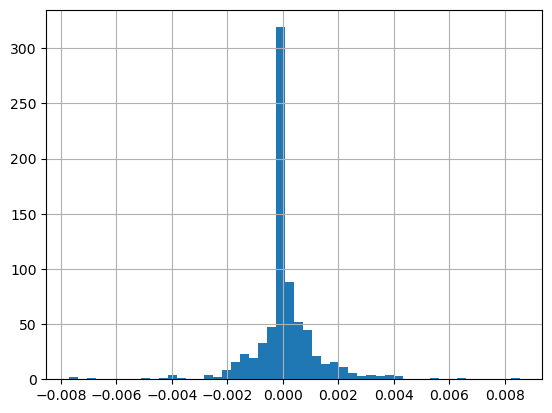

In [74]:
# Histogram of the daily returns
perf.returns.hist(bins=50)

<Axes: >

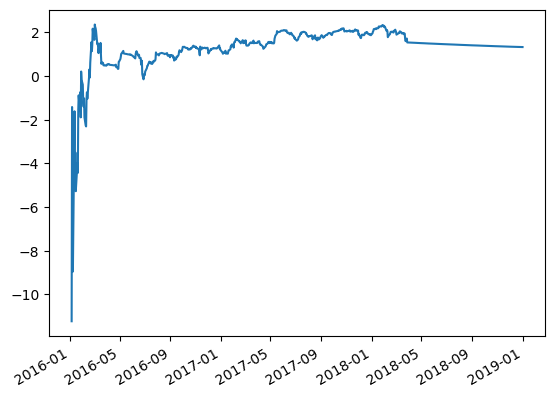

In [76]:
perf.sharpe.plot()